# Clustering

In [1]:
from typing import List, Type, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import fetch_openml
from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Zbiór danych

W zadaniu poddany analizie będzie zbiór MNIST.

In [2]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [3]:
X = mnist.data[:2000]
y = mnist.target[:2000]

In [24]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(30)
X_pca = pca.fit_transform(X_scaled)

In [25]:
X_embedded = TSNE(n_components=2).fit_transform(X_pca)
X_embedded.shape

(2000, 2)

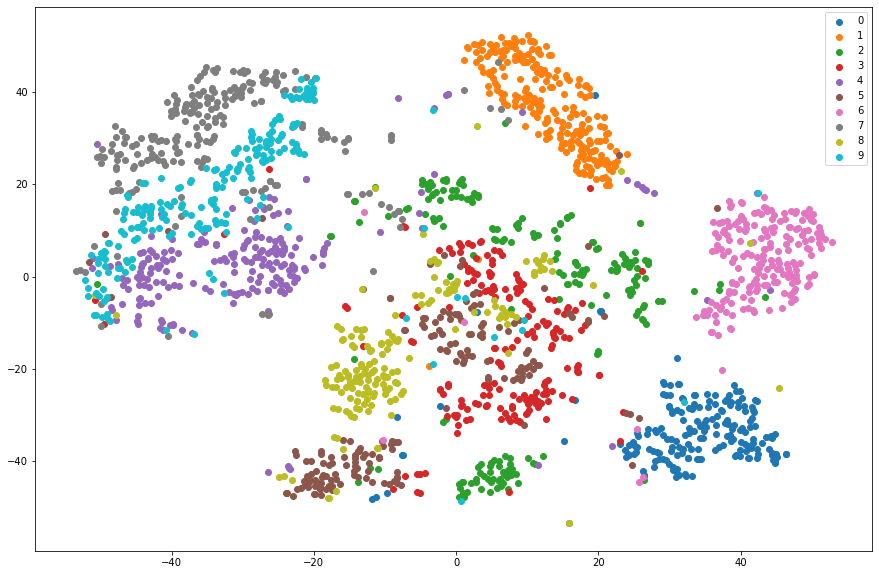

In [26]:
ids = [str(i) for i in range(10)]
plt.figure(figsize=(15, 10))

for c, label in zip(mcolors.TABLEAU_COLORS, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=13)
X_train.shape

(1600, 30)

## Metody cluteringu
Podstawowe algorytmy clusteringu na przeskalowanym zbiorze MNIST.

In [7]:
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering, DBSCAN, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram

### K-Means
Wymagane jest, aby podać liczbę klastrów.

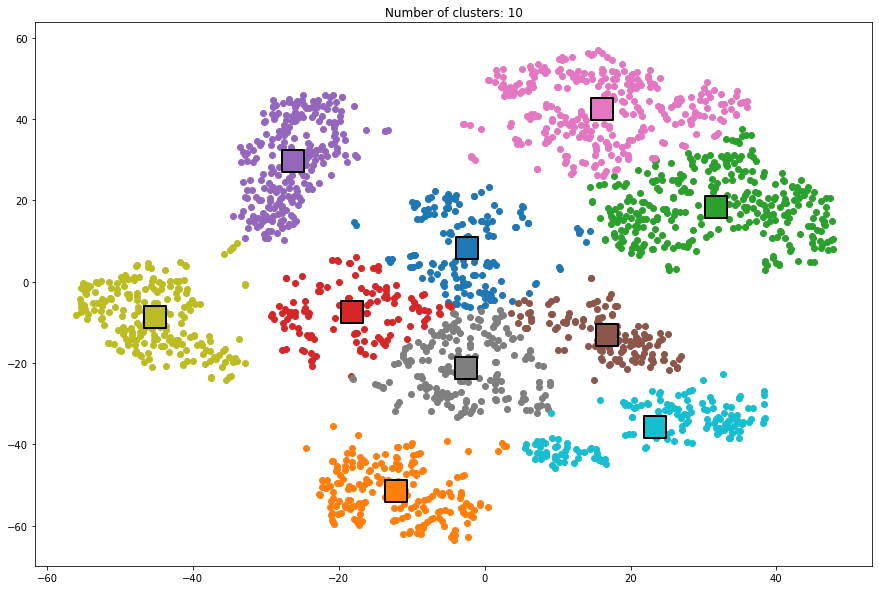

In [8]:
plt.figure(figsize=(15, 10))

km = KMeans(
    n_clusters=10,
).fit(X_embedded, y)

labels = km.labels_
cluster_centers = km.cluster_centers_
n_clusters_ = len(np.unique(labels))

for k, col in zip(range(n_clusters_), mcolors.TABLEAU_COLORS):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.scatter(X_embedded[my_members, 0], X_embedded[my_members, 1], c=col)
    plt.scatter(cluster_center[0], cluster_center[1], marker='s', c=col, s=500, edgecolors='black', linewidth='2')
plt.title('Number of clusters: %d' % n_clusters_)
plt.show()

### MeanShift
W tym przypadku nie podajemy liczby klastrów, a pasmo.

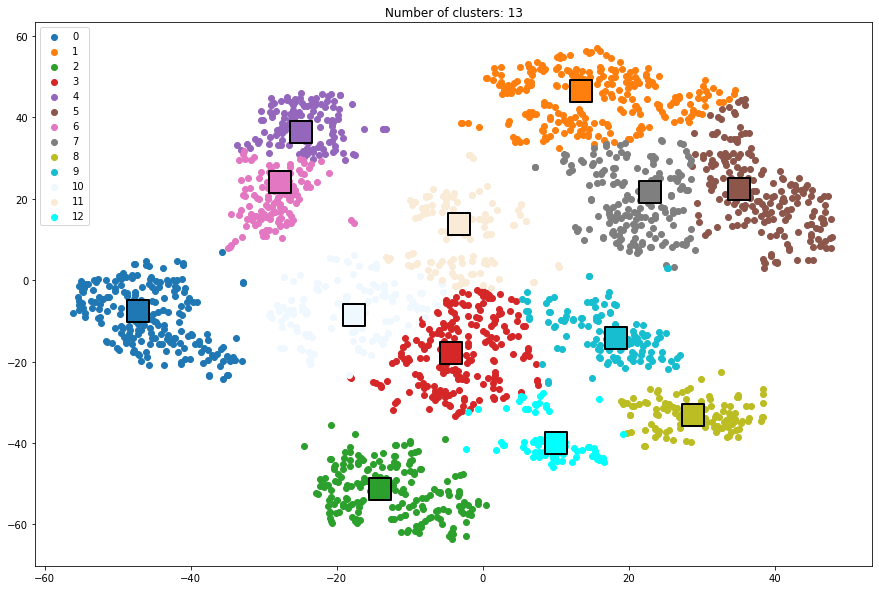

In [9]:
bandwidth = estimate_bandwidth(X_embedded, quantile=0.05)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X_embedded)

plt.figure(figsize=(15, 10))

labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ = len(np.unique(labels))

colors = dict(mcolors.TABLEAU_COLORS, **mcolors.CSS4_COLORS)

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.scatter(X_embedded[my_members, 0], X_embedded[my_members, 1], c=col, label=k)
    plt.scatter(cluster_center[0], cluster_center[1], marker='s', c=col, s=500, edgecolors='black', linewidth='2')
plt.title('Number of clusters: %d' % n_clusters_)
plt.legend()
plt.show()

### DBSCAN
Ten rodzaj clusteringu nie przewiduje obliczanych centrów, jednak wyróżnia punkty Noise (oznaczane na czarno) oraz punkty brzegowe (z czarnym obramowaniem)

Estimated number of noise points: 64


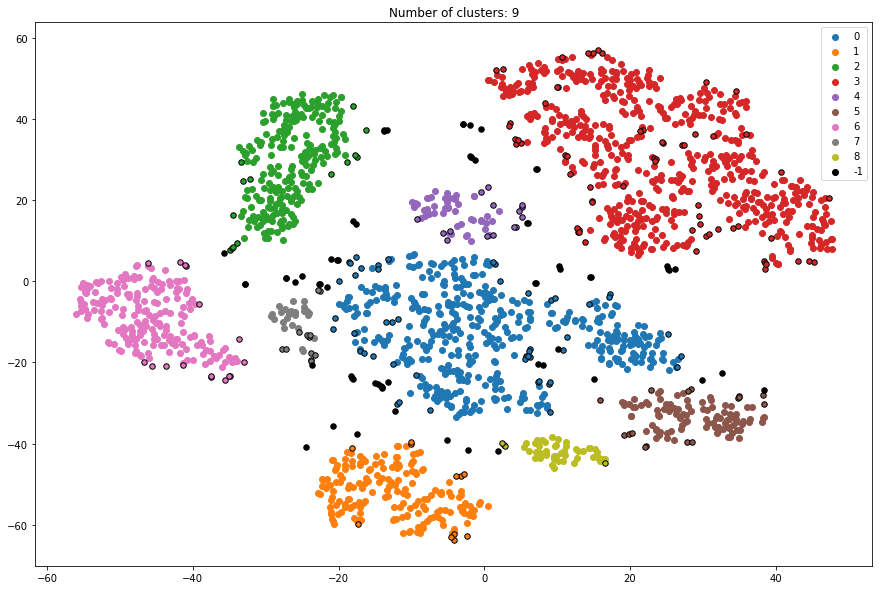

In [10]:
db = DBSCAN(eps=3.7, min_samples=10).fit(X_embedded)

plt.figure(figsize=(15, 10))

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of noise points: %d' % n_noise_)

unique_labels = set(labels)

colors = dict(mcolors.TABLEAU_COLORS, **mcolors.CSS4_COLORS)

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'black'
    
    class_member_mask = (labels == k)
    xy = X_embedded[class_member_mask & core_samples_mask]

    plt.scatter(xy[:, 0], xy[:, 1], c=col, label=k)
    
    xy = X_embedded[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=col, s=30, edgecolors='black', linewidth='1')
    
plt.title('Number of clusters: %d' % n_clusters_)
plt.legend()
plt.show()

### Agglomerative Hierarchical Clustering
Podajemy liczbę klastrów oraz kryterum, które będzie brane pod uwagę przy minimalizacji.

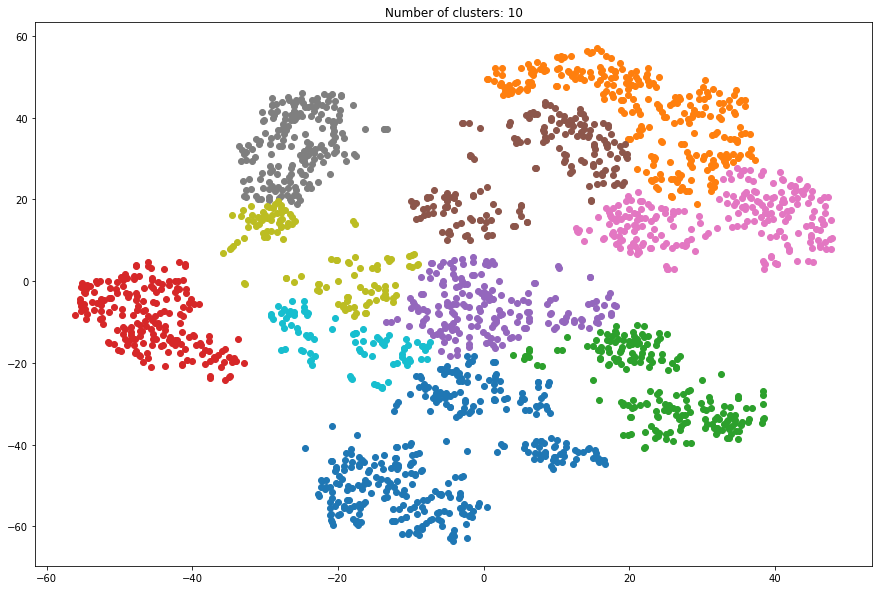

In [11]:
plt.figure(figsize=(15, 10))

linkage = ["ward", "complete", "average", "single"]

agg = AgglomerativeClustering(
    n_clusters=10,linkage=linkage[1]
).fit(X_embedded)

labels = agg.labels_
n_clusters_ = len(np.unique(labels))

for k, col in zip(range(n_clusters_), mcolors.TABLEAU_COLORS):
    my_members = labels == k
    plt.scatter(X_embedded[my_members, 0], X_embedded[my_members, 1], c=col)
plt.title('Number of clusters: %d' % n_clusters_)
plt.show()

Możliwe jest wyświetlenie hierarchii, przy czym zmniejszymy zbiór dla większej szybkości wykonania obliczeń

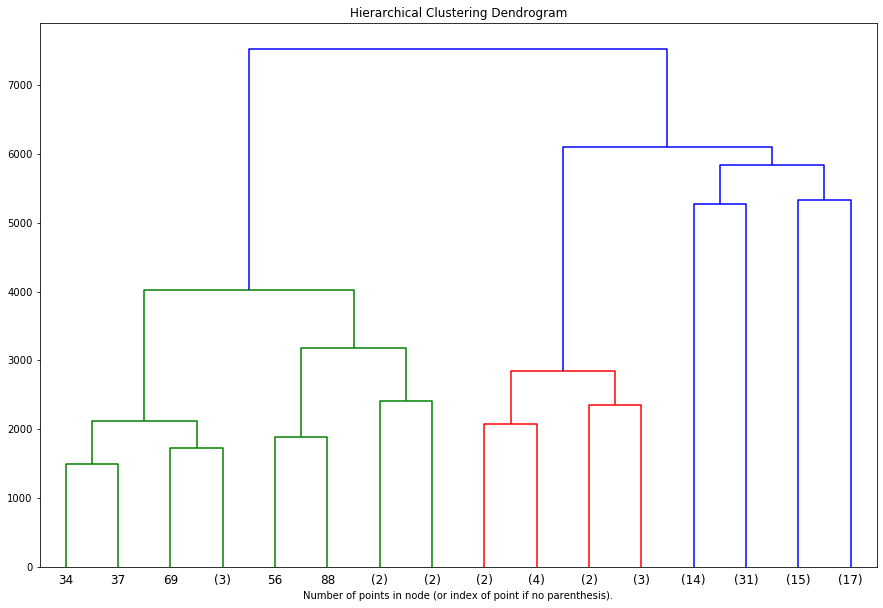

In [12]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

test_size = 100
X_small = mnist.data[:test_size]

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X_small)

plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### GaussianMixture

[0 2 8 ... 6 1 2]


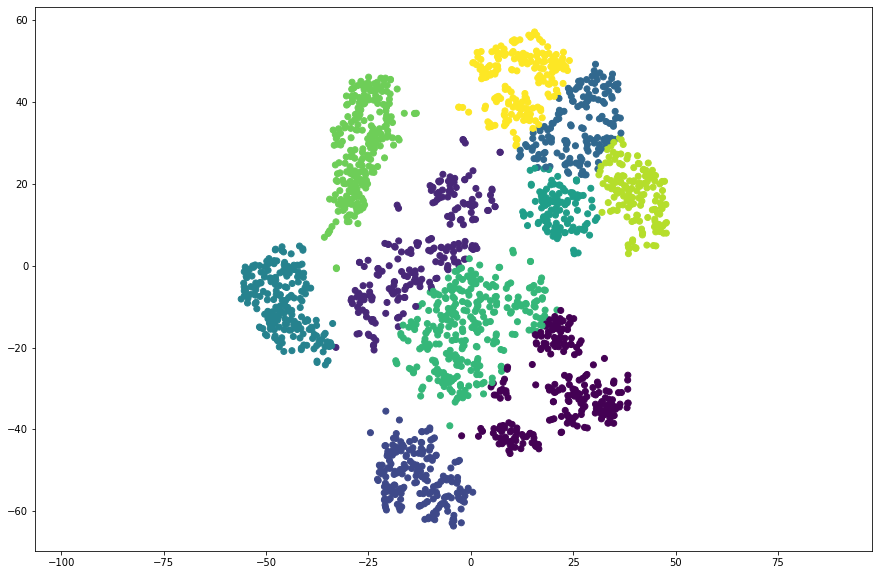

In [13]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, **kwargs):
    ax = plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        for nsig in range(1, 4):
            ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

        
def plot_gmm(gmm, X):
    ax = plt.gca()
    labels = gmm.fit(X).predict(X)
    print(labels)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    else:
        ax.scatter(X[:, 0], X[:, 1])
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        

plt.figure(figsize=(15, 10))

gmm = GaussianMixture(n_components=10, covariance_type='full').fit(X_embedded)

plot_gmm(gmm, X_embedded)

## Miary jakości

Pomiary dokładności clustering'u bedą przeprowadzane na wcześniej przygotowanych danych.  
Dla ułatwienie wszystkie przykłady korzystają z clustering'u KMeans.

In [14]:
from sklearn import metrics
from sklearn.metrics import (silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score, 
                             davies_bouldin_score, pairwise_distances)
from sklearn.metrics.cluster import contingency_matrix

In [15]:
kmeans_model = KMeans(n_clusters=10, random_state=1).fit(X)
labels = kmeans_model.labels_

### Silhouette
Silhouette Coefficient nie wymaga znajomości prawdziwych wartości etykiet klastrów. 
Dla dobrze zdefiniowanych klastrów jego wartość jest wysoka.  
Do jego obliczenia korzysta z odległości pomiędzy próbką a pozostałymi punktami należącymi do tej samej klasy oraz odległości pomiędzy próbką a pozostałymi punktami należącymi do najbliżej położonego klastra.

In [16]:
# Funkcja silhouette_samples oblicza wartość Silhouette dla każdej próbki
sil_samples = silhouette_samples(X, labels)

# Z kolei silhouete_score oblicza wartość średnią
sil_score = silhouette_score(X, labels, metric='euclidean')

print("Silhouette samples:")
print(sil_samples)
print(len(sil_samples))

print("\nSilhouette mean:")
print(sil_score)


Silhouette samples:
[ 0.00406431  0.18413525  0.01296723 ...  0.06710581 -0.02658622
  0.17007733]
2000

Silhouette mean:
0.06967691303664557


### Caliński-Harabasz Index
Calinski-Harabasz Index (Variance Ratio Criterion) jest zdefiniowany jako stosunek dyspersji pomiędzy klastrami oraz dyspersji wewnątrz klastra, gdzie dyspersję definiuje się jako sumę kwadratów odległości.
Indeks jest wysoki, gdy klastry są gęste oraz dobrze odseparowane.


In [17]:
calinski_score = calinski_harabasz_score(X, labels)

print("Calinski-Harbasz index:")
print(calinski_score)

Calinski-Harbasz index:
81.15907014886125


### Davies-Bouldin Index
Indeks ten można interpetować jako średnie "podobieństwo" między klastrami.  
Zero to najniższy możliwy wynik. Wartości bliższe zeru dowodzą o lepszym podziale.


In [18]:
davies_score = davies_bouldin_score(X, labels)

print("Davies-Bouldin index:")
print(davies_score)

Davies-Bouldin index:
2.6360621436778358


### Contingency Matrix

In [19]:
kmeans_model = KMeans(n_clusters=10, random_state=1)
y_pred = kmeans_model.fit_predict(X)

contingency_matrix(y, y_pred)

array([[  6,   6,   0,   0,   3,  14,   5,   3,   0, 154],
       [ 96,   0, 122,   0,   0,   0,   1,   0,   1,   0],
       [ 32,   7,  11, 110,   7,  18,   2,   5,   5,   1],
       [ 29,   1,   0,   9, 125,   8,  10,   5,   2,   2],
       [ 16,   2,   5,   1,   0,  54,   0, 127,   9,   0],
       [ 14,   5,   0,   0,  70,  67,   9,  11,   0,   4],
       [ 21, 149,   2,   1,   0,  11,   1,  13,   0,   2],
       [ 17,   0,   9,   0,   0,  16,   0,  38, 144,   0],
       [ 32,   2,   1,   0,  16,   5, 109,   6,   1,   0],
       [ 24,   0,   1,   0,   5,  19,   1,  83,  75,   2]])

### Purity

In [20]:
def purity_score(model, X, y_true):
    if hasattr(model, 'labels_'):
        y_pred = model.labels_
    else:
        y_pred = model.predict(X)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [21]:
model = KMeans(n_clusters=10, random_state=1).fit(X)

purity_score(model, X, y)

0.6015

### Porównanie metryk jakości

In [28]:
def get_scores(model, X, y):
    scores = []
    
    if type(model) is GaussianMixture:
        labels = model.predict(X)
    else:
        labels = model.labels_
        
    scores.append(silhouette_score(X, labels, metric='euclidean'))
    scores.append(calinski_harabasz_score(X, labels))
    scores.append(davies_bouldin_score(X, labels))
    scores.append(purity_score(model, X, y))
    
    return scores
    

In [29]:
import pandas as pd

X=X_train
y=y_train

index = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'Purity']

km_model = KMeans(n_clusters=10, random_state=1).fit(X)
bandwidth = estimate_bandwidth(X, quantile=0.05)
ms_model = MeanShift(bandwidth=bandwidth).fit(X)
db_model = DBSCAN(eps=3.7, min_samples=10).fit(X)
agg_model = AgglomerativeClustering(n_clusters=10,linkage="complete").fit(X)
gmm_model = GaussianMixture(n_components=10, covariance_type='full').fit(X)


d = {"KMeans": get_scores(km_model, X, y),
     "MeanShift": get_scores(ms_model, X, y),
     "DBSCAN": get_scores(db_model, X, y),
     "Agglomerative": get_scores(agg_model, X , y), 
     "GaussianMixture": get_scores(gmm_model, X, y)} 
df = pd.DataFrame(d, index).transpose()
print(df)

                 Silhouette  Calinski-Harabasz  Davies-Bouldin    Purity
KMeans             0.113361          95.641507        2.066726  0.518125
MeanShift          0.099306          14.347965        1.089281  0.235625
DBSCAN            -0.129640          22.539192        1.725551  0.172500
Agglomerative      0.281513          25.301962        1.050524  0.131875
GaussianMixture    0.082365          87.654027        2.130835  0.529375


### Student project

a) Use 5 top clustering algorithm on FMIST or CIFAR 10 data set. Which algorithm is the best (on thebasis of clustering quality metrics).  
BE CAREFUL. DO IT FOR THE BEST CLUSTERING PARAMETERS AND PROPERLY SELECTED NUMBER OF CLUSTERS.

b) Do the same as in (a) but for the dataset transformed by PCA to 30-D space

c) Does preclustering of data can help in achieving better performance of classification algorithms? How
to do that? (top grade)